# baseline


CV | 15121.815522879584

PrivateLB | 26707.419

In [20]:
MODEL_NAME = 'baseline'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from functools import partial

import lightgbm as lgb

import json

from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [3]:
import time

from contextlib import contextmanager


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [4]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

In [5]:
numeric_columns = ['index','Order', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Mo Sold', 'Yr Sold', 'SalePrice']

string_columns = ['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Paved Drive', 'Sale Type',
       'Sale Condition']

In [6]:
def pre_process(df, phase='train'):
    df = df.drop(['Wood Deck SF'], axis=1)
    if(phase == 'train'):
        df = df[df['MS SubClass'] < 150]
        df = df[df['Lot Area'] < 15000]
        df = df[df['1st Flr SF'] < 1800]
        df = df[(df['SalePrice'] > 100000) & (df['SalePrice'] < 200000)]
    
    return df

In [7]:
df_train = pre_process(df_train, phase="train")
df_test = pre_process(df_test, phase="test")

In [8]:
encoder = Pipeline([
    SelectCategorical(exclude_cols=[]),
    LabelEncoder(output_suffix=""),
])
encoded_df_train = encoder.fit_transform(df_train)
encoded_df_test = encoder.transform(df_test)

In [9]:
df_train = pd.concat([SelectNumerical().fit_transform(df_train), encoded_df_train], axis=1)
df_test = pd.concat([SelectNumerical().fit_transform(df_test), encoded_df_test], axis=1)

In [10]:
X_train = df_train.drop(['index', 'SalePrice'], axis=1)
y_train = df_train['SalePrice']

In [11]:
folds = KFold(n_splits=5, shuffle=True,random_state=42)

In [12]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

In [13]:
# from optuna.integration import lightgbm as lgb_op

# best_params = {}

# with timer("wait"):
#     for train_index, val_index in folds.split(X_train, y_train):
#         lgb_train = lgb.Dataset(X_train.iloc[train_index], y_train.iloc[train_index])
#         lgb_eval = lgb.Dataset(X_train.iloc[val_index], y_train.iloc[val_index], reference=lgb_train)
#         best = lgb_op.train(params,
#                          lgb_train,
#                          valid_sets=lgb_eval,
#                          verbose_eval=False,
#                          num_boost_round=1000,
#                          early_stopping_rounds=30,
#                         )
#         best_params = (best.params)
#         break

# best_params

In [14]:
params = {'objective': 'regression',
             'metric': 'rmse',
             'verbose': -1,
             'feature_pre_filter': False,
             'lambda_l1': 1.9246603611247695,
             'lambda_l2': 0.0015207873611208637,
             'num_leaves': 45,
             'feature_fraction': 0.616,
             'bagging_fraction': 1.0,
             'bagging_freq': 0,
             'min_child_samples': 20,
}

In [15]:
#folds = KFold(n_splits=5, shuffle=True,random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

model = lgb.cv(params,
                 lgb_train,
                 folds=folds,
                 num_boost_round=1000,
                 early_stopping_rounds=10,
                 return_cvbooster=True,
                )

cv_score = model['rmse-mean'][-1]


15121.815522879584


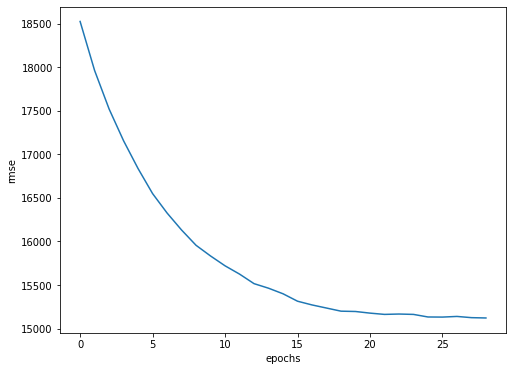

In [16]:
_,ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('epochs')
ax.set_ylabel('rmse')
ax.plot(np.arange(0,len(model['rmse-mean'])),model['rmse-mean'])

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

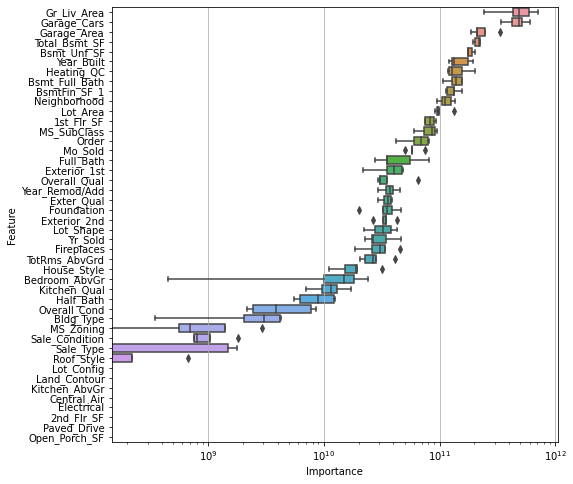

In [17]:
cvbooster = model['cvbooster']

raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_names = cvbooster.boosters[0].feature_name()
df_importance = pd.DataFrame(data=raw_importances, columns=feature_names)

# 平均値ソート
sorted_indices = df_importance.mean(axis=0).sort_values(ascending=False).index
sorted_df_importance = df_importance.loc[:, sorted_indices]

#PLOT_TOP_N = 40
#plot_cols = sorted_df_importance.columns[:PLOT_TOP_N]
plot_cols = sorted_df_importance.columns
_, ax = plt.subplots(figsize=(8,8))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_df_importance[plot_cols],
           orient='h',
           ax=ax)

In [18]:
# X_test = df_test.drop(['index'], axis=1)

# predicted = np.zeros(X_test.shape[0])
# for i in np.arange(len(cvbooster.boosters)):
#     predicted += cvbooster.boosters[i].predict(X_test) / len(cvbooster.boosters)

# output = pd.DataFrame({'index':df_test['index'],'predicted': predicted})
# output.to_csv('./output/submit.csv', index=False, header=False)

In [19]:
# import json
# import datetime

# meta = {
#     'model':MODEL_NAME,
#     'cv_score':cv_score,
#     'created_at':datetime.datetime.now().strftime('%Y%m%d%H%M%S')
# }

# with open('./output/submit.json', 'w') as f:
#     json.dump(meta, f)

In [21]:
print(cv_score)

15121.815522879584
